## **Drive Access**

In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Libraries

In [90]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import cv2
import time
import json
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import xml.etree.ElementTree as ET
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [91]:
sys.path.append('/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/')
from train import train_model
from data_utils import create_validation_data
from vis_utils import imshow

**Annotation & Helper** functions

In [92]:
def get_model(model_name, num_classes, pretrained=True):
    return models.__dict__[model_name](pretrained)

import xml.etree.ElementTree as ET


def read_all_annotations(root_dir, convert_labels_to_int=True):
    """
    root_dir: ŸæŸàÿ¥Ÿá‚Äåÿß€å ⁄©Ÿá ŸÅÿß€åŸÑ‚ÄåŸáÿß€å .xml ÿØÿ± ÿ¢ŸÜ ŸÇÿ±ÿßÿ± ÿØÿßÿ±ŸÜÿØ
    convert_labels_to_int: ÿß⁄Øÿ± True ÿ®ÿßÿ¥ÿØÿå labelŸáÿß ÿ®Ÿá ÿπÿØÿØ ÿ™ÿ®ÿØ€åŸÑ ŸÖ€å‚Äåÿ¥ŸàŸÜÿØ
    """
    annos = {}
    label_to_int = {}
    label_counter = 0

    xml_files = glob(os.path.join(root_dir, '*.xml'))

    for xml_file in xml_files:
        tree = ET.parse(xml_file)
        root = tree.getroot()

        filename = root.find('filename').text.strip()
        objects = root.findall('object')

        if not objects:
            continue

        boxes = []
        labels = []

        for obj in objects:
            label = obj.find('name').text.strip()

            if convert_labels_to_int:
                if label not in label_to_int:
                    label_to_int[label] = label_counter
                    label_counter += 1
                label = label_to_int[label]  # ÿ™ÿ®ÿØ€åŸÑ ÿ®Ÿá ÿπÿØÿØ

            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        annos[filename] = {
            'boxes': boxes,
            'labels': labels
        }

    return annos


def bbox_to_r1c1r2c2(bbox):
    x = bbox['x']
    y = bbox['y']
    w = bbox['width']
    h = bbox['height']
    return [y, x, y + h, x + w]  # [r1, c1, r2, c2]


def plot_bbox(img, bbox, w, h, color='red'):
    """ Plot bounding box on the image tensor.
    """
    img = img.cpu().numpy().transpose((1, 2, 0))  # (H, W, C)

    # denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    # scale
    hs, ws = img.shape[:2]
    h_scale = h / hs
    w_scale = w / ws

    bb = np.array(bbox, dtype=np.float32)
    bx, by = bb[1], bb[0]
    bw = bb[3] - bb[1]
    bh = bb[2] - bb[0]

    bx *= w * w_scale
    by *= h * h_scale
    bw *= w * w_scale
    bh *= h * h_scale

    # scale image
    img = cv2.resize(img, (w, h))

    # create BB rectangle
    rect = plt.Rectangle((bx, by), bw, bh, color=color, fill=False, lw=3)

    # plot
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(img)
    plt.gca().add_patch(rect)
    plt.show()

## Data

In [93]:
DATA_DIR = "/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets"

train_dir = f'{DATA_DIR}/train'
print(train_dir)
valid_dir = f'{DATA_DIR}/valid'
print(valid_dir)
#anno_dir = f'{DATA_DIR}/annotations'

sz = 299  # image size
bs = 32   # batch size
model_name = 'resnet34'
num_classes = 8

/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train
/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/valid


### Files structure

In [94]:
print(os.listdir(DATA_DIR))

['README.dataset.txt', 'README.roboflow.txt', 'train', 'valid', 'test', 'annotations']


In [95]:
# all images for each fish class is in a separate directory
print(os.listdir(f'{DATA_DIR}/train'))

['881_png.rf.a9d8cc00e9522b8e7fca302c44516e15.xml', '609_png.rf.71155561209d46822d238361ccf00977.xml', '1867_png.rf.158504767e0c1c729eb956e284226bc5.xml', '1260_png.rf.a17d5b6f475a669d9e25dde83ce6a2cb.xml', '1160_png.rf.34dfa2dfbafc88ab4ccf92d4bde83886.xml', '1086_png.rf.f7581982f5765b920ee8b023b2efb628.xml', '220_png.rf.2b23b31bee7061e6670b6e65d9abc752.xml', '715_png.rf.81ae9abda0eedc6f5dad71b6f3091249.xml', '1828_png.rf.f46ddf6697b01256a1b53ae30f0ef321.xml', '1123_png.rf.e2fb70241f29bf1a81217283d4bd7fcc.xml', '1256_png.rf.473cc23534d7da4fa536fbdf1887f5a3.xml', '268_png.rf.47f7926b3be1b2b8ba38b2d83ab0eabe.xml', '221_png.rf.f0e320d4667864be19d370937374209c.xml', '1162_png.rf.a4ef34a1700f800d8ff46c1af1be73c1.xml', '948_png.rf.dd1c8e9d18360ccd86b3ec8e876b687f.xml', '663_png.rf.ff214636bf86b07138c0413031532af8.xml', '674_png.rf.b15aa49eb971813387542ae9ea664609.xml', '633_png.rf.fe6cd5f42edaedbb6a73c67e60e76b2b.jpg', '1590_png.rf.d7e6a5eaba11ece5074b940abf2dadd2.xml', '1456_png.rf.2e60df59

In [96]:
files = glob(f'{DATA_DIR}/train/*.jpg')

files[:5]

['/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/633_png.rf.fe6cd5f42edaedbb6a73c67e60e76b2b.jpg',
 '/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/515_png.rf.f9121afe38c38ff6d75595a923992326.jpg',
 '/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/94_png.rf.416143d4efdad648b71312a9541e0a4c.jpg',
 '/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/767_png.rf.fd084782d91a43632664e9e0e600c144.jpg',
 '/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/1863_png.rf.3ba919653775064d6b9f80b8a002b0f3.jpg']

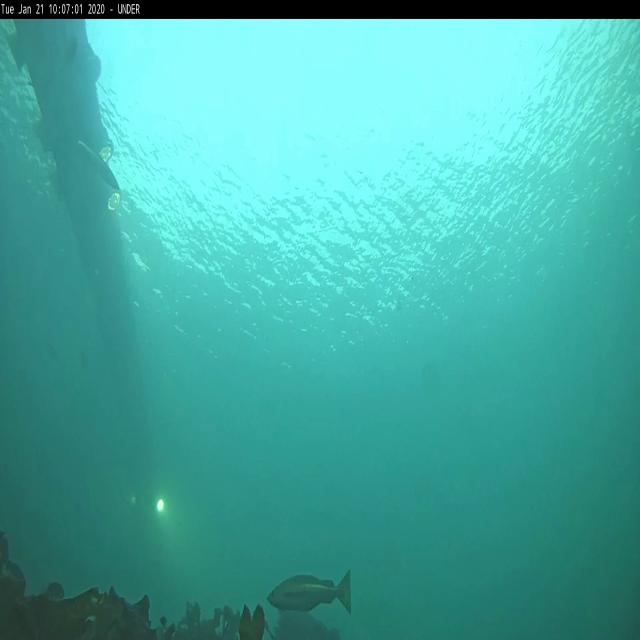

In [97]:
Image.open(files[3])

### Fish Dataset

Creat a simple class for images

In [98]:
#⁄ÜŸàŸÜ ŸÅÿß€åŸÑ ÿßÿ∑ŸÑÿßÿπÿßÿ™ ÿπ⁄©ÿ≥ Ÿáÿß Ÿà ÿπ⁄©ÿ≥ Ÿáÿß ÿ®ÿß ŸáŸÖ ŸÇÿßÿ∑€å ÿßŸÜÿØ Ÿà ŸæŸàÿ¥Ÿá ÿ®ŸÜÿØ€å ÿ¨ÿØÿß⁄ØÿßŸÜŸá ŸÜÿ¥ÿØŸá ÿßŸÜÿØ
#ÿπ⁄©ÿ≥ Ÿáÿß €åÿπŸÜ€å ÿπ⁄©ÿ≥ Ÿáÿ± ŸÖÿßŸá€å ÿ™Ÿà ŸæŸàÿ¥Ÿá ÿÆŸàÿØÿ¥ÿå ÿßŸàŸÑ €åŸá ⁄©ŸÑÿßÿ≥ ÿ≥ÿßÿØŸá ŸÖ€åÿ≥ÿßÿ≤€åŸÖ ⁄©ŸáŸÅŸÇÿ∑ ÿπ⁄©ÿ≥ Ÿáÿß ÿ±Ÿà ŸÑ€åÿ≥ÿ™ ⁄©ŸÜŸá ÿ®ÿπÿØ ŸÖ€åŸÅÿ±ÿ≥ÿ™€åŸÖ ÿ®Ÿá ⁄©ŸÑÿßÿ≥Fishdataset
from torchvision.datasets.folder import default_loader

class SimpleImageDataset:
    def __init__(self, root):
        self.imgs = [(f, 0) for f in glob(os.path.join(root, '*.jpg'))]
        self.classes = ['fish']  # ŸÖŸÇÿØÿßÿ± ÿßŸàŸÑ€åŸá ŸÅŸÇÿ∑


In [211]:
import os
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import torch

# class FishDataset(Dataset):
#     def __init__(self, ds, bboxes, classes, class_to_idx, sz=299):
#         """
#         ds: ŸÖÿ¨ŸÖŸàÿπŸá ÿ™ÿµÿßŸà€åÿ± (ÿßÿ≤ ImageFolder)
#         bboxes: ÿØ€å⁄©ÿ¥ŸÜÿ±€å ÿ¥ÿßŸÖŸÑ 'boxes' Ÿà 'labels' ÿ®ÿ±ÿß€å Ÿáÿ± ÿ™ÿµŸà€åÿ±
#         classes: ŸÑ€åÿ≥ÿ™ ⁄©ŸÑÿßÿ≥‚ÄåŸáÿß
#         class_to_idx: ÿØ€å⁄©ÿ¥ŸÜÿ±€å ŸÜ⁄Øÿßÿ¥ÿ™ ŸÜÿßŸÖ ⁄©ŸÑÿßÿ≥ ÿ®Ÿá ÿßŸÜÿØ€åÿ≥
#         sz: ÿßŸÜÿØÿßÿ≤Ÿá ŸÜŸáÿß€å€å ÿ™ÿµŸà€åÿ±
#         """
#         self.imgs = ds.imgs  # ŸÑ€åÿ≥ÿ™ ÿ™ÿßŸæŸÑ‚ÄåŸáÿß€å (ŸÖÿ≥€åÿ±, label)
#         self.classes = classes
#         self.bboxes = bboxes
#         self.class_to_idx = class_to_idx
#         self.sz = sz
#         self.image_paths = [img[0] for img in ds.imgs]  # ÿ∞ÿÆ€åÿ±Ÿá ŸÖÿ≥€åÿ±Ÿáÿß€å ÿ™ÿµÿßŸà€åÿ±
#         # ŸÜŸÖÿß€åÿ¥ ⁄©ŸÑÿßÿ≥‚ÄåŸáÿß€å ŸÖŸàÿ¨ŸàÿØ
#         print("⁄©ŸÑÿßÿ≥‚ÄåŸáÿß€å ŸÖŸàÿ¨ŸàÿØ:")
#         print(self.classes)
#         print("\nclass_to_idx:")
#         print(self.class_to_idx)

#         # Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸÜ ÿ®ÿ±⁄Üÿ≥ÿ®‚ÄåŸáÿß€å ŸÖŸÜÿ≠ÿµÿ± ÿ®Ÿá ŸÅÿ±ÿØ ÿØÿ± ÿØ€åÿ™ÿßÿ≥ÿ™
#         all_labels = set()
#         for bbox_info in self.bboxes.values():
#           all_labels.update(map(str, bbox_info['labels']))

#           print("\nÿ®ÿ±⁄Üÿ≥ÿ®‚ÄåŸáÿß€å ŸÖŸàÿ¨ŸàÿØ ÿØÿ± ÿØ€åÿ™ÿßÿ≥ÿ™:", all_labels)

#         # ÿ®ÿ±⁄Üÿ≥ÿ®‚ÄåŸáÿß€å ⁄ØŸÖ‚Äåÿ¥ÿØŸá
#         missing_labels = all_labels - set(self.class_to_idx.keys())
#         if missing_labels:
#           print("\n‚ö†Ô∏è ÿ®ÿ±⁄Üÿ≥ÿ®‚ÄåŸáÿß€å ⁄ØŸÖ‚Äåÿ¥ÿØŸá:", missing_labels)
#           # ÿßÿ∂ÿßŸÅŸá ⁄©ÿ±ÿØŸÜ ÿÆŸàÿØ⁄©ÿßÿ± (ÿßÿÆÿ™€åÿßÿ±€å)
#           for idx, label in enumerate(missing_labels, start=len(self.class_to_idx)):
#             self.class_to_idx[label] = idx
#             print(f"ÿßÿ∂ÿßŸÅŸá ÿ¥ÿØ: {label} -> {idx}")

#         self.tfms = transforms.Compose([
#             transforms.Resize((sz, sz)),
#             transforms.ToTensor(),
#             transforms.Normalize([0.485, 0.456, 0.406],
#                                [0.229, 0.224, 0.225])
#         ])

#     def __getitem__(self, index):
#      img_path, _ = self.imgs[index]
#      img_name = os.path.basename(img_path)

#      image = Image.open(img_path).convert('RGB')
#      w, h = image.size
#      w_scale = self.sz / w
#      h_scale = self.sz / h

#      image = self.tfms(image)

#      boxes = []
#      labels = []

#      if img_name in self.bboxes:
#         bbox_info = self.bboxes[img_name]
#         for box, label in zip(bbox_info['boxes'], bbox_info['labels']):
#             # ÿ™ÿ®ÿØ€åŸÑ ÿ®Ÿá ŸÖÿÆÿ™ÿµÿßÿ™ ŸÜÿ≥ÿ®€å [0-1]
#             x1 = box[0] / w
#             y1 = box[1] / h
#             x2 = box[2] / w
#             y2 = box[3] / h

#             boxes.append([x1, y1, x2, y2])

#             # ÿ™ÿ®ÿØ€åŸÑ ÿ®ÿ±⁄Üÿ≥ÿ® ÿ®ÿß ÿ®ÿ±ÿ±ÿ≥€å Ÿàÿ¨ŸàÿØ ÿØÿ± class_to_idx
#             try:
#                 # ÿ®ÿ±ÿ±ÿ≥€å ŸáŸÖ ÿ®ÿ±ÿß€å ÿπÿØÿØ€å Ÿà ŸáŸÖ ÿ±ÿ¥ÿ™Ÿá‚Äåÿß€å
#                 if isinstance(label, str):
#                     label_idx = self.class_to_idx[label]
#                 else:
#                     label_idx = self.class_to_idx[str(label)]
#                 labels.append(label_idx)
#             except KeyError:
#                 print(f"‚ö†Ô∏è Ÿáÿ¥ÿØÿßÿ±: ÿ®ÿ±⁄Üÿ≥ÿ® {label} (ŸÜŸàÿπ: {type(label)}) ÿØÿ± class_to_idx Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ!")
#                 continue  # €åÿß ŸÖŸÇÿØÿßÿ± Ÿæ€åÿ¥‚ÄåŸÅÿ±ÿ∂ ŸÇÿ±ÿßÿ± ÿØŸá€åÿØ

#                 boxes = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32)
#                 labels = torch.tensor(labels, dtype=torch.long) if labels else torch.zeros((0,), dtype=torch.long)
#                 return image, labels, boxes, (w, h), img_path

# def __len__(self):
#           return len(self.imgs)




class FishDataset(Dataset):
    def __init__(self, ds, bboxes, classes, class_to_idx, sz=299):
        """
        ds: ŸÖÿ¨ŸÖŸàÿπŸá ÿ™ÿµÿßŸà€åÿ± (ÿßÿ≤ ImageFolder)
        bboxes: ÿØ€å⁄©ÿ¥ŸÜÿ±€å ÿ¥ÿßŸÖŸÑ 'boxes' Ÿà 'labels' ÿ®ÿ±ÿß€å Ÿáÿ± ÿ™ÿµŸà€åÿ±
        classes: ŸÑ€åÿ≥ÿ™ ⁄©ŸÑÿßÿ≥‚ÄåŸáÿß
        class_to_idx: ÿØ€å⁄©ÿ¥ŸÜÿ±€å ŸÜ⁄Øÿßÿ¥ÿ™ ŸÜÿßŸÖ ⁄©ŸÑÿßÿ≥ ÿ®Ÿá ÿßŸÜÿØ€åÿ≥
        sz: ÿßŸÜÿØÿßÿ≤Ÿá ŸÜŸáÿß€å€å ÿ™ÿµŸà€åÿ±
        """
        self.imgs = ds.imgs  # ŸÑ€åÿ≥ÿ™ ÿ™ÿßŸæŸÑ‚ÄåŸáÿß€å (ŸÖÿ≥€åÿ±, label)
        self.classes = classes
        self.bboxes = bboxes
        self.class_to_idx = class_to_idx
        self.sz = sz
        self.image_paths = [img[0] for img in ds.imgs]  # ÿ∞ÿÆ€åÿ±Ÿá ŸÖÿ≥€åÿ±Ÿáÿß€å ÿ™ÿµÿßŸà€åÿ±

        # ŸÜŸÖÿß€åÿ¥ ⁄©ŸÑÿßÿ≥‚ÄåŸáÿß€å ŸÖŸàÿ¨ŸàÿØ
        print("⁄©ŸÑÿßÿ≥‚ÄåŸáÿß€å ŸÖŸàÿ¨ŸàÿØ:")
        print(self.classes)
        print("\nclass_to_idx:")
        print(self.class_to_idx)

        # Ÿæ€åÿØÿß ⁄©ÿ±ÿØŸÜ ÿ®ÿ±⁄Üÿ≥ÿ®‚ÄåŸáÿß€å ŸÖŸÜÿ≠ÿµÿ± ÿ®Ÿá ŸÅÿ±ÿØ ÿØÿ± ÿØ€åÿ™ÿßÿ≥ÿ™
        all_labels = set()
        for bbox_info in self.bboxes.values():
            all_labels.update(map(str, bbox_info['labels']))

        print("\nÿ®ÿ±⁄Üÿ≥ÿ®‚ÄåŸáÿß€å ŸÖŸàÿ¨ŸàÿØ ÿØÿ± ÿØ€åÿ™ÿßÿ≥ÿ™:", all_labels)

        # ÿ®ÿ±⁄Üÿ≥ÿ®‚ÄåŸáÿß€å ⁄ØŸÖ‚Äåÿ¥ÿØŸá
        missing_labels = all_labels - set(self.class_to_idx.keys())
        if missing_labels:
            print("\n‚ö†Ô∏è ÿ®ÿ±⁄Üÿ≥ÿ®‚ÄåŸáÿß€å ⁄ØŸÖ‚Äåÿ¥ÿØŸá:", missing_labels)
            # ÿßÿ∂ÿßŸÅŸá ⁄©ÿ±ÿØŸÜ ÿÆŸàÿØ⁄©ÿßÿ± (ÿßÿÆÿ™€åÿßÿ±€å)
            for idx, label in enumerate(missing_labels, start=len(self.class_to_idx)):
                self.class_to_idx[label] = idx
                print(f"ÿßÿ∂ÿßŸÅŸá ÿ¥ÿØ: {label} -> {idx}")

        self.tfms = transforms.Compose([
            transforms.Resize((sz, sz)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                               [0.229, 0.224, 0.225])
        ])

    def __getitem__(self, index):
        img_path, _ = self.imgs[index]
        img_name = os.path.basename(img_path)

        image = Image.open(img_path).convert('RGB')
        w, h = image.size
        w_scale = self.sz / w
        h_scale = self.sz / h

        image = self.tfms(image)

        boxes = []
        labels = []

        if img_name in self.bboxes:
            bbox_info = self.bboxes[img_name]
            for box, label in zip(bbox_info['boxes'], bbox_info['labels']):
                # ÿ™ÿ®ÿØ€åŸÑ ÿ®Ÿá ŸÖÿÆÿ™ÿµÿßÿ™ ŸÜÿ≥ÿ®€å [0-1]
                x1 = box[0] / w
                y1 = box[1] / h
                x2 = box[2] / w
                y2 = box[3] / h

                boxes.append([x1, y1, x2, y2])

                # ÿ™ÿ®ÿØ€åŸÑ ÿ®ÿ±⁄Üÿ≥ÿ® ÿ®ÿß ÿ®ÿ±ÿ±ÿ≥€å Ÿàÿ¨ŸàÿØ ÿØÿ± class_to_idx
                try:
                    # ÿ®ÿ±ÿ±ÿ≥€å ŸáŸÖ ÿ®ÿ±ÿß€å ÿπÿØÿØ€å Ÿà ŸáŸÖ ÿ±ÿ¥ÿ™Ÿá‚Äåÿß€å
                    if isinstance(label, str):
                        label_idx = self.class_to_idx[label]
                    else:
                        label_idx = self.class_to_idx[str(label)]
                    labels.append(label_idx)
                except KeyError:
                    print(f"‚ö†Ô∏è Ÿáÿ¥ÿØÿßÿ±: ÿ®ÿ±⁄Üÿ≥ÿ® {label} (ŸÜŸàÿπ: {type(label)}) ÿØÿ± class_to_idx Ÿàÿ¨ŸàÿØ ŸÜÿØÿßÿ±ÿØ!")
                    continue  # €åÿß ŸÖŸÇÿØÿßÿ± Ÿæ€åÿ¥‚ÄåŸÅÿ±ÿ∂ ŸÇÿ±ÿßÿ± ÿØŸá€åÿØ

        boxes = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long) if labels else torch.zeros((0,), dtype=torch.long)

        return image, labels, boxes, (w, h), img_path

    def __len__(self):
        return len(self.imgs)

### Training and Validation dataset

In [212]:
def extract_classes_from_xml(dataset_dirs):
    """
    dataset_dirs: ŸÑ€åÿ≥ÿ™€å ÿßÿ≤ ŸÖÿ≥€åÿ±Ÿáÿß ÿ®Ÿá ŸæŸàÿ¥Ÿá‚ÄåŸáÿß€å train Ÿà valid
    ÿÆÿ±Ÿàÿ¨€å: ÿØ€å⁄©ÿ¥ŸÜÿ±€å class_to_idx
    """
    classes = set()

    for dataset_dir in dataset_dirs:
        for file in os.listdir(dataset_dir):
            if file.endswith('.xml'):
                xml_path = os.path.join(dataset_dir, file)
                try:
                    tree = ET.parse(xml_path)
                    root = tree.getroot()
                    for obj in root.findall('object'):
                        name = obj.find('name').text
                        classes.add(name)
                except Exception as e:
                    print(f"ÿÆÿ∑ÿß ÿØÿ± ŸÅÿß€åŸÑ {file}: {e}")

    sorted_classes = sorted(list(classes))
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted_classes)}
    return class_to_idx


In [213]:
# def collate_fn(batch):
#     imgs, lbls, bbs, sizes = zip(*batch)
#     imgs = torch.stack(imgs, 0)
#     return imgs, lbls, bbs, sizes

# def collate_fn(batch):
#     """
#     ÿ™ÿßÿ®ÿπ ÿ¨ÿØ€åÿØ ÿ®ÿ±ÿß€å Ÿæÿ±ÿØÿßÿ≤ÿ¥ batchŸáÿß ÿ®ÿß ÿ™Ÿàÿ¨Ÿá ÿ®Ÿá ÿ≥ÿßÿÆÿ™ÿßÿ± ÿ¨ÿØ€åÿØ ÿØ€åÿ™ÿßÿ≥ÿ™
#     """
#     # ÿ¨ÿØÿß ⁄©ÿ±ÿØŸÜ ÿßÿ¨ÿ≤ÿß€å ŸÖÿÆÿ™ŸÑŸÅ batch
#     imgs, lbls, bbs, sizes, img_paths = zip(*batch)

#     # ÿß€åÿ¨ÿßÿØ ÿ™ŸÜÿ≥Ÿàÿ±Ÿáÿß€å ŸÜŸáÿß€å€å
#     imgs = torch.stack(imgs, 0)  # ÿ¨ŸÖÿπ‚Äåÿ¢Ÿàÿ±€å ÿ™ÿµÿßŸà€åÿ±
#     lbls = list(lbls)  # ŸÑ€åÿ≥ÿ™ ÿ®ÿ±⁄Üÿ≥ÿ®‚ÄåŸáÿß
#     bbs = list(bbs)    # ŸÑ€åÿ≥ÿ™ ÿ®ÿß⁄©ÿ≥‚ÄåŸáÿß
#     sizes = list(sizes) # ŸÑ€åÿ≥ÿ™ ÿßŸÜÿØÿßÿ≤Ÿá‚ÄåŸáÿß
#     img_paths = list(img_paths) # ŸÑ€åÿ≥ÿ™ ŸÖÿ≥€åÿ±Ÿáÿß

#     return imgs, lbls, bbs, sizes  # €åÿß ÿß⁄Øÿ± ÿ®Ÿá ŸÖÿ≥€åÿ±Ÿáÿß ŸÜ€åÿßÿ≤ ÿØÿßÿ±€åÿØ: return imgs, lbls, bbs, sizes, img_paths

def collate_fn(batch):
    """
    ŸÜÿ≥ÿÆŸá ÿß€åŸÖŸÜ‚Äåÿ™ÿ± ÿ®ÿ±ÿß€å collate_fn
    """
    batch = [x for x in batch if x is not None]  # ÿ≠ÿ∞ŸÅ ŸÜŸÖŸàŸÜŸá‚ÄåŸáÿß€å ŸÜÿßŸÖÿπÿ™ÿ®ÿ±
    if not batch:
        return torch.Tensor(), torch.Tensor(), torch.Tensor(), torch.Tensor()

    imgs, lbls, bbs, sizes, paths = zip(*batch)

    return (
        torch.stack(imgs, 0),
        lbls,  # ŸÑ€åÿ≥ÿ™ ÿ™ŸÜÿ≥Ÿàÿ±Ÿáÿß
        bbs,   # ŸÑ€åÿ≥ÿ™ ÿ™ŸÜÿ≥Ÿàÿ±Ÿáÿß
        sizes,
        paths  # ÿßÿÆÿ™€åÿßÿ±€å
    )

    return imgs, lbls, bbs, sizes  # €åÿß ÿß⁄Øÿ± ÿ®Ÿá ŸÖÿ≥€åÿ±Ÿáÿß ŸÜ€åÿßÿ≤ ÿØÿßÿ±€åÿØ: return imgs, lbls, bbs, sizes, img_paths

Creat Validation Data

In [214]:
if not os.path.exists(valid_dir):
    create_validation_data(train_dir, valid_dir, split=0.2, ext='jpg')

In [215]:
# ÿÆŸàÿßŸÜÿØŸÜ annotation Ÿà ⁄©ŸÑÿßÿ≥‚ÄåŸáÿß
bb_json = read_all_annotations(train_dir)

# ÿßÿ≥ÿ™ÿÆÿ±ÿßÿ¨ ŸÑ€åÿ≥ÿ™ €å⁄©ÿ™ÿß ÿßÿ≤ ⁄©ŸÑÿßÿ≥‚ÄåŸáÿß
all_classes = sorted(list(set(label for v in bb_json.values() for label in v['labels'])))

# ÿ≥ÿßÿÆÿ™ ÿØ€å⁄©ÿ¥ŸÜÿ±€å class_to_idx
class_to_idx = {cls: i for i, cls in enumerate(all_classes)}

# ÿØ€åÿ™ÿßÿ≥ÿ™ Ÿà ÿØ€åÿ™ÿßŸÑŸàÿØÿ± ÿ¢ŸÖŸàÿ≤ÿ¥
train_data = SimpleImageDataset(train_dir)
train_ds = FishDataset(train_data, bboxes=bb_json, classes=all_classes, class_to_idx=class_to_idx, sz=sz)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, collate_fn=collate_fn)

# ÿØ€åÿ™ÿßÿ≥ÿ™ Ÿà ÿØ€åÿ™ÿßŸÑŸàÿØÿ± ÿßÿπÿ™ÿ®ÿßÿ±ÿ≥ŸÜÿ¨€å
valid_data = SimpleImageDataset(valid_dir)
valid_ds = FishDataset(valid_data, bboxes=bb_json, classes=all_classes, class_to_idx=class_to_idx, sz=sz)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, collate_fn=collate_fn)


⁄©ŸÑÿßÿ≥‚ÄåŸáÿß€å ŸÖŸàÿ¨ŸàÿØ:
[0, 1, 2, 3, 4, 5, 6]

class_to_idx:
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

ÿ®ÿ±⁄Üÿ≥ÿ®‚ÄåŸáÿß€å ŸÖŸàÿ¨ŸàÿØ ÿØÿ± ÿØ€åÿ™ÿßÿ≥ÿ™: {'4', '0', '5', '1', '2', '3', '6'}

‚ö†Ô∏è ÿ®ÿ±⁄Üÿ≥ÿ®‚ÄåŸáÿß€å ⁄ØŸÖ‚Äåÿ¥ÿØŸá: {'0', '4', '5', '1', '2', '3', '6'}
ÿßÿ∂ÿßŸÅŸá ÿ¥ÿØ: 0 -> 7
ÿßÿ∂ÿßŸÅŸá ÿ¥ÿØ: 4 -> 8
ÿßÿ∂ÿßŸÅŸá ÿ¥ÿØ: 5 -> 9
ÿßÿ∂ÿßŸÅŸá ÿ¥ÿØ: 1 -> 10
ÿßÿ∂ÿßŸÅŸá ÿ¥ÿØ: 2 -> 11
ÿßÿ∂ÿßŸÅŸá ÿ¥ÿØ: 3 -> 12
ÿßÿ∂ÿßŸÅŸá ÿ¥ÿØ: 6 -> 13
⁄©ŸÑÿßÿ≥‚ÄåŸáÿß€å ŸÖŸàÿ¨ŸàÿØ:
[0, 1, 2, 3, 4, 5, 6]

class_to_idx:
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, '0': 7, '4': 8, '5': 9, '1': 10, '2': 11, '3': 12, '6': 13}

ÿ®ÿ±⁄Üÿ≥ÿ®‚ÄåŸáÿß€å ŸÖŸàÿ¨ŸàÿØ ÿØÿ± ÿØ€åÿ™ÿßÿ≥ÿ™: {'4', '0', '5', '1', '2', '3', '6'}


Check annotations

In [216]:
print(f"ÿ™ÿπÿØÿßÿØ ⁄©ŸÑ ⁄©ŸÑ€åÿØŸáÿß ÿØÿ± bb_json: {len(bb_json)}")
print(f"ŸÜŸàÿπ ÿØÿßÿØŸá bb_json: {type(bb_json)}")
print("⁄©ŸÑ€åÿØŸáÿß:", list(bb_json.keys()))
print("Image Name:",list(bb_json.keys())[5])  # ŸÜŸÖÿß€åÿ¥ 5 ÿ™ÿµŸà€åÿ± ÿßŸàŸÑ

ÿ™ÿπÿØÿßÿØ ⁄©ŸÑ ⁄©ŸÑ€åÿØŸáÿß ÿØÿ± bb_json: 1315
ŸÜŸàÿπ ÿØÿßÿØŸá bb_json: <class 'dict'>
⁄©ŸÑ€åÿØŸáÿß: ['881_png.rf.a9d8cc00e9522b8e7fca302c44516e15.jpg', '609_png.rf.71155561209d46822d238361ccf00977.jpg', '1867_png.rf.158504767e0c1c729eb956e284226bc5.jpg', '1260_png.rf.a17d5b6f475a669d9e25dde83ce6a2cb.jpg', '1160_png.rf.34dfa2dfbafc88ab4ccf92d4bde83886.jpg', '1086_png.rf.f7581982f5765b920ee8b023b2efb628.jpg', '220_png.rf.2b23b31bee7061e6670b6e65d9abc752.jpg', '715_png.rf.81ae9abda0eedc6f5dad71b6f3091249.jpg', '1828_png.rf.f46ddf6697b01256a1b53ae30f0ef321.jpg', '1123_png.rf.e2fb70241f29bf1a81217283d4bd7fcc.jpg', '1256_png.rf.473cc23534d7da4fa536fbdf1887f5a3.jpg', '268_png.rf.47f7926b3be1b2b8ba38b2d83ab0eabe.jpg', '221_png.rf.f0e320d4667864be19d370937374209c.jpg', '1162_png.rf.a4ef34a1700f800d8ff46c1af1be73c1.jpg', '948_png.rf.dd1c8e9d18360ccd86b3ec8e876b687f.jpg', '663_png.rf.ff214636bf86b07138c0413031532af8.jpg', '674_png.rf.b15aa49eb971813387542ae9ea664609.jpg', '1590_png.rf.d7e6a5eab

In [217]:
print(bb_json['1086_png.rf.f7581982f5765b920ee8b023b2efb628.jpg'])
print(bb_json['609_png.rf.71155561209d46822d238361ccf00977.jpg'])

{'boxes': [[230, 175, 299, 219], [2, 274, 30, 363]], 'labels': [2, 3]}
{'boxes': [[434, 515, 461, 538]], 'labels': [1]}


### Visulaize data

In [218]:
# dataiter = iter(train_dl)
# imgs, lbls, bbs, sizes = next(dataiter)

# # ÿß€åÿ¨ÿßÿØ grid ÿ®ÿ±ÿß€å ÿ™ÿµÿßŸà€åÿ±
# img = torchvision.utils.make_grid(imgs, nrow=8)

# # ÿ¢ŸÖÿßÿØŸá‚Äåÿ≥ÿßÿ≤€å ÿ™ÿµÿßŸà€åÿ± ÿ®ÿ±ÿß€å ŸÜŸÖÿß€åÿ¥
# plt.figure(figsize=(16, 8))
# imshow(img, title='A random batch of training data')

# # ŸÜŸÖÿß€åÿ¥ ÿ™ÿµÿßŸà€åÿ± ÿ®ÿØŸàŸÜ ÿ±ÿ≥ŸÖ ÿ¨ÿπÿ®Ÿá‚ÄåŸáÿß€å ŸÖÿ≠ÿØŸàÿØ⁄©ŸÜŸÜÿØŸá
# plt.show()


def imshow(inp, title=None):
    """ŸÜŸÖÿß€åÿ¥ ÿ™ŸÜÿ≥Ÿàÿ± ÿ™ÿµŸà€åÿ±"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# ÿØÿ±€åÿßŸÅÿ™ €å⁄© batch ÿßÿ≤ ÿØÿßÿØŸá‚ÄåŸáÿß
dataiter = iter(train_dl)
imgs, lbls, bbs, sizes = next(dataiter)  # ÿß⁄Øÿ± ŸÖÿ≥€åÿ±Ÿáÿß ÿ±ÿß ŸÜ€åÿßÿ≤ ŸÜÿØÿßÿ±€åÿØ

# €åÿß ÿß⁄Øÿ± ÿ®Ÿá ŸÖÿ≥€åÿ±Ÿáÿß ŸÜ€åÿßÿ≤ ÿØÿßÿ±€åÿØ:
# imgs, lbls, bbs, sizes, img_paths = next(dataiter)

# ÿß€åÿ¨ÿßÿØ grid ÿ®ÿ±ÿß€å ÿ™ÿµÿßŸà€åÿ±
img_grid = torchvision.utils.make_grid(imgs, nrow=8)

# ŸÜŸÖÿß€åÿ¥ ÿ™ÿµÿßŸà€åÿ±
plt.figure(figsize=(16, 8))
imshow(img_grid, title='A random batch of training data')
plt.show()

# ŸÜŸÖÿß€åÿ¥ ÿßÿ∑ŸÑÿßÿπÿßÿ™ ÿØ€åÿ®ÿß⁄Ø
print(f"ÿßÿ®ÿπÿßÿØ batch ÿ™ÿµÿßŸà€åÿ±: {imgs.shape}")
print(f"ÿ™ÿπÿØÿßÿØ ÿ®ÿ±⁄Üÿ≥ÿ®‚ÄåŸáÿß ÿØÿ± batch: {len(lbls)}")
print(f"ÿ™ÿπÿØÿßÿØ ÿ®ÿß⁄©ÿ≥‚ÄåŸáÿß ÿØÿ± batch: {len(bbs)}")
print(f"ŸÜŸÖŸàŸÜŸá ÿßŸàŸÑ€åŸÜ ÿ®ÿ±⁄Üÿ≥ÿ®: {lbls[0]}")
print(f"ŸÜŸÖŸàŸÜŸá ÿßŸàŸÑ€åŸÜ ÿ®ÿß⁄©ÿ≥: {bbs[0]}")
print(f"ŸÜŸÖŸàŸÜŸá ÿßŸÜÿØÿßÿ≤Ÿá ÿßŸàŸÑ: {sizes[0]}")

ValueError: too many values to unpack (expected 4)

In [172]:
# import matplotlib.pyplot as plt
# import torch
# import numpy as np
# file_name = train_ds.imgs[5][0]  # ŸÅÿ±ÿ∂ ÿ®ÿ± ÿß€åŸÜ ⁄©Ÿá ŸÖÿ≥€åÿ± ŸÅÿß€åŸÑ ÿ™ÿµŸà€åÿ± ÿØÿ± train_ds.imgs ÿ∞ÿÆ€åÿ±Ÿá ÿ¥ÿØŸá ÿ®ÿßÿ¥ÿØ
# print(file_name)


In [173]:
# import matplotlib.pyplot as plt
# import torch
# import numpy as np
# import os
# import xml.etree.ElementTree as ET

# def show_sample_with_debug(dataset, idx, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
#     """
#     ŸÜŸÖÿß€åÿ¥ €å⁄© ŸÜŸÖŸàŸÜŸá ÿ®ÿß ÿßÿ∑ŸÑÿßÿπÿßÿ™ ÿØ€åÿ®ÿß⁄Ø ⁄©ÿßŸÖŸÑ (ŸÜÿ≥ÿÆŸá ÿßÿµŸÑÿßÿ≠ ÿ¥ÿØŸá ÿ®ÿØŸàŸÜ ŸÜ€åÿßÿ≤ ÿ®Ÿá image_paths)
#     """
#     # ÿØÿ±€åÿßŸÅÿ™ ŸÜŸÖŸàŸÜŸá ÿßÿ≤ ÿØ€åÿ™ÿßÿ≥ÿ™
#     img, label, bboxes, (orig_w, orig_h) = dataset[idx]

#     # ⁄ÜÿßŸæ ÿßÿ∑ŸÑÿßÿπÿßÿ™ Ÿæÿß€åŸá
#     print("\n" + "="*50)
#     print(f"ŸÜŸÖŸàŸÜŸá ÿ¥ŸÖÿßÿ±Ÿá {idx}")
#     print(f"ÿßÿ®ÿπÿßÿØ ÿßÿµŸÑ€å: {orig_w}x{orig_h}")
#     print(f"ÿ®ÿ±⁄Üÿ≥ÿ®: {label}")
#     print(f"Bounding BoxŸáÿß€å ÿÆÿßŸÖ ÿßÿ≤ ÿØ€åÿ™ÿßÿ≥ÿ™: {bboxes}")

#     # Unnormalize ÿ™ÿµŸà€åÿ±
#     img = img.clone()
#     for t, m, s in zip(img, mean, std):
#         t.mul_(s).add_(m)
#     img = img.permute(1, 2, 0).numpy()
#     img = np.clip(img, 0, 1)

#     # ÿß€åÿ¨ÿßÿØ figure
#     plt.figure(figsize=(10, 10))

#     # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ŸÜÿ≥ÿ®ÿ™ ÿ™ÿ∫€å€åÿ± ÿßŸÜÿØÿßÿ≤Ÿá
#     scale_x = img.shape[1] / orig_w
#     scale_y = img.shape[0] / orig_h

#     # ŸÜŸÖÿß€åÿ¥ ÿ™ÿµŸà€åÿ± ÿ®ÿß ÿ®ÿß⁄©ÿ≥‚ÄåŸáÿß€å ÿØ€åÿ™ÿßÿ≥ÿ™
#     plt.imshow(img)

#     for i, bbox in enumerate(bboxes):
#         xmin, ymin, xmax, ymax = bbox
#         xmin = xmin.item() * scale_x
#         ymin = ymin.item() * scale_y
#         xmax = xmax.item() * scale_x
#         ymax = ymax.item() * scale_y

#         # ÿ±ÿ≥ŸÖ ÿ®ÿß⁄©ÿ≥
#         plt.gca().add_patch(plt.Rectangle(
#             (xmin, ymin), xmax-xmin, ymax-ymin,
#             fill=False, edgecolor='red', linewidth=2))

#         # ŸÜŸÖÿß€åÿ¥ ÿßÿ∑ŸÑÿßÿπÿßÿ™ ÿ®ÿß⁄©ÿ≥
#         box_info = f"Box {i}\n({xmin:.1f},{ymin:.1f})-({xmax:.1f},{ymax:.1f})"
#         plt.text(xmin, ymin-10, box_info, color='white',
#                 fontsize=8, bbox=dict(facecolor='red', alpha=0.7))

#     plt.title(f'ŸÜŸÖŸàŸÜŸá {idx} - ÿßÿ®ÿπÿßÿØ: {img.shape[1]}x{img.shape[0]}')
#     plt.axis('off')
#     plt.show()

#     # ⁄ÜÿßŸæ ÿ¨ÿ≤ÿ¶€åÿßÿ™ ÿ™ÿ®ÿØ€åŸÑ
#     print("\nŸÖÿÆÿ™ÿµÿßÿ™ Ÿæÿ≥ ÿßÿ≤ ÿ™ÿ®ÿØ€åŸÑ:")
#     for i, bbox in enumerate(bboxes):
#         xmin, ymin, xmax, ymax = bbox
#         print(f"Box {i}:")
#         print(f"  x: [{xmin.item()*scale_x:.1f}, {xmax.item()*scale_x:.1f}]")
#         print(f"  y: [{ymin.item()*scale_y:.1f}, {ymax.item()*scale_y:.1f}]")
#         print(f"  ÿπÿ±ÿ∂: {xmax.item()*scale_x - xmin.item()*scale_x:.1f}px")
#         print(f"  ÿßÿ±ÿ™ŸÅÿßÿπ: {ymax.item()*scale_y - ymin.item()*scale_y:.1f}px")

# # ŸÖÿ´ÿßŸÑ ÿßÿ≥ÿ™ŸÅÿßÿØŸá:
# show_sample_with_debug(train_ds, 0)  # ŸÜŸÖÿß€åÿ¥ ÿßŸàŸÑ€åŸÜ ŸÜŸÖŸàŸÜŸá
# show_sample_with_debug(train_ds, 5)  # ŸÜŸÖÿß€åÿ¥ ŸÜŸÖŸàŸÜŸá


import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
from PIL import Image

def show_sample_with_debug(dataset, idx, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    ŸÜŸÖÿß€åÿ¥ ⁄©ÿßŸÖŸÑ €å⁄© ŸÜŸÖŸàŸÜŸá ÿ®ÿß ÿ™ŸÖÿßŸÖ ÿßÿ∑ŸÑÿßÿπÿßÿ™ ÿØ€åÿ®ÿß⁄Ø
    """
    # ÿØÿ±€åÿßŸÅÿ™ ŸÜŸÖŸàŸÜŸá ÿßÿ≤ ÿØ€åÿ™ÿßÿ≥ÿ™
    img, labels, bboxes, (orig_w, orig_h), img_path = dataset[idx]
    img_name = os.path.basename(img_path)
    xml_path = img_path.replace('.jpg', '.xml').replace('.png', '.xml')

    # ⁄ÜÿßŸæ ÿßÿ∑ŸÑÿßÿπÿßÿ™ ÿØ€åÿ®ÿß⁄Ø
    print("\n" + "="*80)
    print(f"üìÅ ŸÜŸÖŸàŸÜŸá ÿ¥ŸÖÿßÿ±Ÿá {idx}")
    print(f"üì∑ ŸÖÿ≥€åÿ± ÿ™ÿµŸà€åÿ±: {img_path}")
    print(f"üìÑ ŸÖÿ≥€åÿ± XML: {xml_path}")
    print(f"üìè ÿßÿ®ÿπÿßÿØ ÿßÿµŸÑ€å: {orig_w}x{orig_h}")
    print(f"üè∑Ô∏è ÿ®ÿ±⁄Üÿ≥ÿ®‚ÄåŸáÿß: {labels.tolist()}")
    print(f"üü¶ Bounding BoxŸáÿß€å ÿÆÿßŸÖ ÿßÿ≤ ÿØ€åÿ™ÿßÿ≥ÿ™:\n{bboxes.tolist()}")

    # ÿÆŸàÿßŸÜÿØŸÜ ŸÖÿ≥ÿ™ŸÇ€åŸÖ ÿßÿ≤ XML ÿ®ÿ±ÿß€å ŸÖŸÇÿß€åÿ≥Ÿá
    xml_boxes = []
    if os.path.exists(xml_path):
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()

            for member in root.findall('object'):
                bndbox = member.find('bndbox')
                xmin = int(float(bndbox.find('xmin').text))
                ymin = int(float(bndbox.find('ymin').text))
                xmax = int(float(bndbox.find('xmax').text))
                ymax = int(float(bndbox.find('ymax').text))
                xml_boxes.append([xmin, ymin, xmax, ymax])

            print(f"üü© Bounding BoxŸáÿß€å ŸàÿßŸÇÿπ€å ÿßÿ≤ XML:\n{xml_boxes}")
        except Exception as e:
            print(f"‚ö†Ô∏è ÿÆÿ∑ÿß ÿØÿ± ÿÆŸàÿßŸÜÿØŸÜ XML: {e}")
            xml_boxes = []
    else:
        print("‚ö†Ô∏è ŸÅÿß€åŸÑ XML €åÿßŸÅÿ™ ŸÜÿ¥ÿØ!")
        xml_boxes = []

    # Unnormalize ÿ™ÿµŸà€åÿ±
    img = img.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ŸÜÿ≥ÿ®ÿ™ ÿ™ÿ∫€å€åÿ± ÿßŸÜÿØÿßÿ≤Ÿá
    scale_x = img.shape[1] / orig_w
    scale_y = img.shape[0] / orig_h

    # ÿß€åÿ¨ÿßÿØ figure
    plt.figure(figsize=(18, 8))

    # 1. ŸÜŸÖÿß€åÿ¥ ÿ™ÿµŸà€åÿ± ÿßÿµŸÑ€å ÿ®ÿß ÿ®ÿß⁄©ÿ≥‚ÄåŸáÿß€å ÿßÿµŸÑ€å
    plt.subplot(1, 3, 1)
    orig_img = Image.open(img_path).convert('RGB')
    plt.imshow(orig_img)
    plt.title(f'ÿ™ÿµŸà€åÿ± ÿßÿµŸÑ€å\n{img_name}\nÿßÿ®ÿπÿßÿØ: {orig_w}x{orig_h}')

    if xml_boxes:
        for i, box in enumerate(xml_boxes):
            xmin, ymin, xmax, ymax = box
            plt.gca().add_patch(plt.Rectangle(
                (xmin, ymin), xmax-xmin, ymax-ymin,
                fill=False, edgecolor='blue', linewidth=2))
            plt.text(xmin, ymin-10, f'XML {i}', color='white',
                    bbox=dict(facecolor='blue', alpha=0.7))

    plt.axis('off')

    # 2. ŸÜŸÖÿß€åÿ¥ ÿ™ÿµŸà€åÿ± Ÿæÿ±ÿØÿßÿ≤ÿ¥ ÿ¥ÿØŸá ÿ®ÿß ÿ®ÿß⁄©ÿ≥‚ÄåŸáÿß€å ÿØ€åÿ™ÿßÿ≥ÿ™
    plt.subplot(1, 3, 2)
    plt.imshow(img)

    for i, bbox in enumerate(bboxes):
        y1, x1, y2, x2 = bbox
        xmin = x1.item() * img.shape[1]
        ymin = y1.item() * img.shape[0]
        xmax = x2.item() * img.shape[1]
        ymax = y2.item() * img.shape[0]

        plt.gca().add_patch(plt.Rectangle(
            (xmin, ymin), xmax-xmin, ymax-ymin,
            fill=False, edgecolor='red', linewidth=2))
        plt.text(xmin, ymin-10, f'DS {i}', color='white',
                bbox=dict(facecolor='red', alpha=0.7))

    plt.title(f'ÿ™ÿµŸà€åÿ± Ÿæÿ±ÿØÿßÿ≤ÿ¥ ÿ¥ÿØŸá\n{img_name}\nÿßÿ®ÿπÿßÿØ: {img.shape[1]}x{img.shape[0]}')
    plt.axis('off')

    # 3. ŸÜŸÖÿß€åÿ¥ ÿ®ÿ≤ÿ±⁄ØŸÜŸÖÿß€å€å ÿ¥ÿØŸá ÿß⁄Øÿ± ÿ®ÿß⁄©ÿ≥‚ÄåŸáÿß ⁄©Ÿà⁄Ü⁄© Ÿáÿ≥ÿ™ŸÜÿØ
    plt.subplot(1, 3, 3)
    plt.imshow(img)

    if len(bboxes) > 0:
        y1, x1, y2, x2 = bboxes[0]
        xmin = x1.item() * img.shape[1]
        ymin = y1.item() * img.shape[0]
        xmax = x2.item() * img.shape[1]
        ymax = y2.item() * img.shape[0]

        plt.gca().add_patch(plt.Rectangle(
            (xmin, ymin), xmax-xmin, ymax-ymin,
            fill=False, edgecolor='lime', linewidth=3))

        # ÿ®ÿ≤ÿ±⁄ØŸÜŸÖÿß€å€å ÿ±Ÿà€å ŸÜÿßÿ≠€åŸá ÿ®ÿß⁄©ÿ≥
        zoom_margin = 50
        plt.xlim(max(0, xmin-zoom_margin), min(img.shape[1], xmax+zoom_margin))
        plt.ylim(min(img.shape[0], ymax+zoom_margin), max(0, ymin-zoom_margin))

        plt.title('ŸÜŸÖÿß€åÿ¥ ÿ®ÿ≤ÿ±⁄ØŸÜŸÖÿß€å€å ÿ¥ÿØŸá')
    else:
        plt.title('ÿ®ÿØŸàŸÜ ÿ®ÿß⁄©ÿ≥')

    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # ⁄ÜÿßŸæ ŸÖŸÇÿß€åÿ≥Ÿá ÿß€å ÿØŸÇ€åŸÇ
    if xml_boxes and len(bboxes) == len(xml_boxes):
        print("\nüîç ŸÖŸÇÿß€åÿ≥Ÿá ÿØŸÇ€åŸÇ ŸÖÿÆÿ™ÿµÿßÿ™:")
        for i, (ds_box, xml_box) in enumerate(zip(bboxes, xml_boxes)):
            y1, x1, y2, x2 = ds_box
            xmin_ds = x1.item() * img.shape[1]
            ymin_ds = y1.item() * img.shape[0]
            xmax_ds = x2.item() * img.shape[1]
            ymax_ds = y2.item() * img.shape[0]

            xmin_xml = xml_box[0] * scale_x
            ymin_xml = xml_box[1] * scale_y
            xmax_xml = xml_box[2] * scale_x
            ymax_xml = xml_box[3] * scale_y

            print(f"\nBox {i}:")
            print(f"  ÿØ€åÿ™ÿßÿ≥ÿ™ -> x: [{xmin_ds:.1f}, {xmax_ds:.1f}] (ÿπÿ±ÿ∂: {xmax_ds-xmin_ds:.1f}px)")
            print(f"           y: [{ymin_ds:.1f}, {ymax_ds:.1f}] (ÿßÿ±ÿ™ŸÅÿßÿπ: {ymax_ds-ymin_ds:.1f}px)")
            print(f"  XML    -> x: [{xmin_xml:.1f}, {xmax_xml:.1f}] (ÿπÿ±ÿ∂: {xmax_xml-xmin_xml:.1f}px)")
            print(f"           y: [{ymin_xml:.1f}, {ymax_xml:.1f}] (ÿßÿ±ÿ™ŸÅÿßÿπ: {ymax_xml-ymin_xml:.1f}px)")
            print(f"  ÿßÿÆÿ™ŸÑÿßŸÅ -> x: {abs(xmin_ds-xmin_xml):.1f}px, y: {abs(ymin_ds-ymin_xml):.1f}px")

# ŸÖÿ´ÿßŸÑ ÿßÿ≥ÿ™ŸÅÿßÿØŸá:
show_sample_with_debug(train_ds, 110)  # ŸÜŸÖÿß€åÿ¥ ÿßŸàŸÑ€åŸÜ ŸÜŸÖŸàŸÜŸá
# show_sample_with_debug(train_ds, 5)  # ŸÜŸÖÿß€åÿ¥ ŸÜŸÖŸàŸÜŸá ÿ¥ÿ¥ŸÖ






KeyError: '1'

In [174]:
def show_single_sample(dataset, idx, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    ŸÜŸÖÿß€åÿ¥ €å⁄© ŸÜŸÖŸàŸÜŸá ÿßÿ≤ ÿØ€åÿ™ÿßÿ≥ÿ™ ÿ®ÿß ÿ®ÿß⁄©ÿ≥‚ÄåŸáÿß
    """
    img, label, bboxes, (orig_w, orig_h) = dataset[idx]

    # Unnormalize
    img = img.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title(f'Label: {label} | Original Size: {orig_w}x{orig_h}')

    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ŸÜÿ≥ÿ®ÿ™ ÿ™ÿ∫€å€åÿ± ÿßŸÜÿØÿßÿ≤Ÿá
    scale_x = img.shape[1] / orig_w
    scale_y = img.shape[0] / orig_h

    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        xmin = xmin.item() * scale_x
        ymin = ymin.item() * scale_y
        xmax = xmax.item() * scale_x
        ymax = ymax.item() * scale_y

        rect = plt.Rectangle(
            (xmin, ymin), xmax-xmin, ymax-ymin,
            fill=False, edgecolor='cyan', linewidth=3)
        plt.gca().add_patch(rect)

        # ŸÜŸÖÿß€åÿ¥ ŸÖÿÆÿ™ÿµÿßÿ™
        plt.text(xmin, ymin-10,
                f"({xmin:.1f},{ymin:.1f})->({xmax:.1f},{ymax:.1f})",
                color='white', fontsize=8,
                bbox=dict(facecolor='blue', alpha=0.7))

    plt.axis('off')
    plt.show()

# ŸÖÿ´ÿßŸÑ ÿßÿ≥ÿ™ŸÅÿßÿØŸá:
show_single_sample(train_ds, 110)  # ŸÜŸÖÿß€åÿ¥ ŸÜŸÖŸàŸÜŸá ŸæŸÜÿ¨ŸÖ

KeyError: '1'

In [175]:
def show_single_sample(dataset, idx, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    ŸÜŸÖÿß€åÿ¥ €å⁄© ŸÜŸÖŸàŸÜŸá ÿßÿ≤ ÿØ€åÿ™ÿßÿ≥ÿ™ ÿ®ÿß ÿ®ÿß⁄©ÿ≥‚ÄåŸáÿß
    """
    img, label, bboxes, (orig_w, orig_h) = dataset[idx]

    # Unnormalize
    img = img.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title(f'Label: {label} | Original Size: {orig_w}x{orig_h}')

    # ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ŸÜÿ≥ÿ®ÿ™ ÿ™ÿ∫€å€åÿ± ÿßŸÜÿØÿßÿ≤Ÿá
    scale_x = img.shape[1] / orig_w
    scale_y = img.shape[0] / orig_h

    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        xmin = xmin.item() * scale_x
        ymin = ymin.item() * scale_y
        xmax = xmax.item() * scale_x
        ymax = ymax.item() * scale_y

        rect = plt.Rectangle(
            (xmin, ymin), xmax-xmin, ymax-ymin,
            fill=False, edgecolor='cyan', linewidth=3)
        plt.gca().add_patch(rect)

        # ŸÜŸÖÿß€åÿ¥ ŸÖÿÆÿ™ÿµÿßÿ™
        plt.text(xmin, ymin-10,
                f"({xmin:.1f},{ymin:.1f})->({xmax:.1f},{ymax:.1f})",
                color='white', fontsize=8,
                bbox=dict(facecolor='blue', alpha=0.7))

    plt.axis('off')
    plt.show()

# ŸÖÿ´ÿßŸÑ ÿßÿ≥ÿ™ŸÅÿßÿØŸá:
show_single_sample(train_ds, 110)  # ŸÜŸÖÿß€åÿ¥ ŸÜŸÖŸàŸÜŸá ŸæŸÜÿ¨ŸÖ

KeyError: '1'

ÿßÿ®ÿπÿßÿØ ÿ™ÿµŸà€åÿ± ÿßÿµŸÑ€å: 640x640
ŸÖÿÆÿ™ÿµÿßÿ™ ŸàÿßŸÇÿπ€å ÿßÿ≤ XML: [[230, 175, 299, 219], [2, 274, 30, 363]]
ŸÜÿ≥ÿ®ÿ™ ÿ™ÿ∫€å€åÿ± ÿßŸÜÿØÿßÿ≤Ÿá: X=0.4672, Y=0.4672
ŸÖÿÆÿ™ÿµÿßÿ™ ÿ™ÿ®ÿØ€åŸÑ ÿ¥ÿØŸá: [[107, 81, 139, 102], [0, 128, 14, 169]]


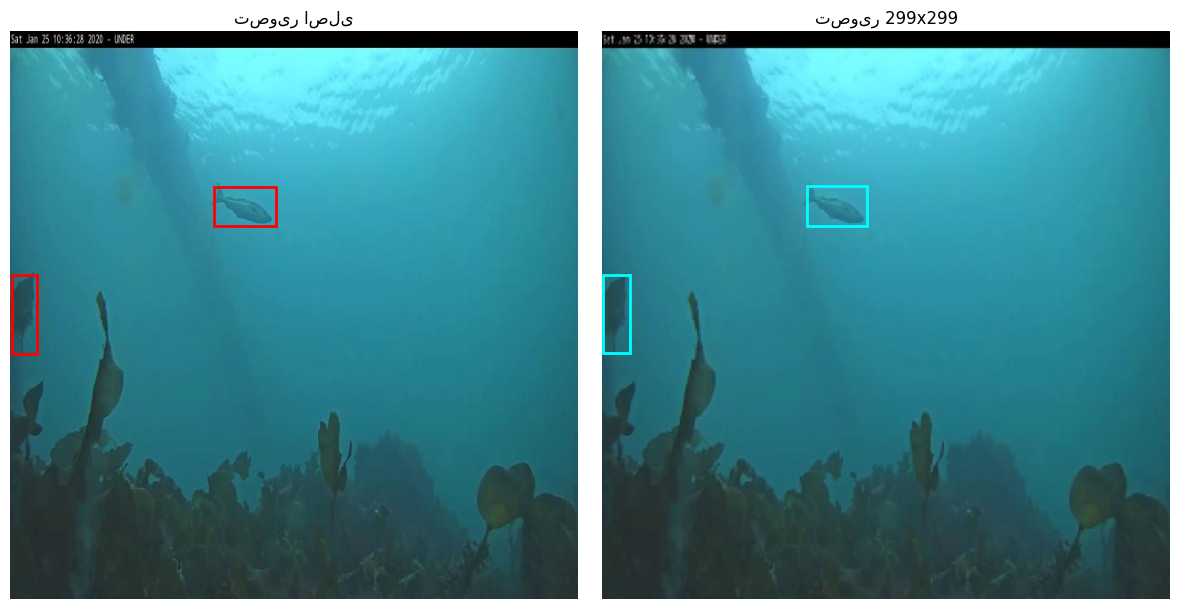


ÿßÿ®ÿπÿßÿØ ÿ®ÿß⁄©ÿ≥ ÿØÿ± ÿ™ÿµŸà€åÿ± ÿ±€åÿ≥ÿß€åÿ≤: ÿπÿ±ÿ∂=32px, ÿßÿ±ÿ™ŸÅÿßÿπ=21px


In [176]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from google.colab.patches import cv2_imshow  # ŸÅŸÇÿ∑ ÿ®ÿ±ÿß€å ⁄ØŸà⁄ØŸÑ ⁄©ŸàŸÑÿ®

# 1. ÿ™ŸÜÿ∏€åŸÖ ŸÖÿ≥€åÿ±Ÿáÿß
image_path = '/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/1086_png.rf.f7581982f5765b920ee8b023b2efb628.jpg'
xml_path = '/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/1086_png.rf.f7581982f5765b920ee8b023b2efb628.xml'

# 2. ÿÆŸàÿßŸÜÿØŸÜ ÿ™ÿµŸà€åÿ±
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # ÿ™ÿ®ÿØ€åŸÑ ÿ®Ÿá RGB
original_height, original_width = img.shape[:2]

print(f"ÿßÿ®ÿπÿßÿØ ÿ™ÿµŸà€åÿ± ÿßÿµŸÑ€å: {original_width}x{original_height}")

# 3. ÿÆŸàÿßŸÜÿØŸÜ ÿ¢ŸÜŸàÿ™€åÿ¥ŸÜ
def read_annotation(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    boxes = []
    for member in root.findall('object'):
        bndbox = member.find('bndbox')
        xmin = int(float(bndbox.find('xmin').text))  # ÿ™ÿ®ÿØ€åŸÑ ÿ®Ÿá float ÿ®ÿ±ÿß€å ÿßÿ∑ŸÖ€åŸÜÿßŸÜ
        ymin = int(float(bndbox.find('ymin').text))
        xmax = int(float(bndbox.find('xmax').text))
        ymax = int(float(bndbox.find('ymax').text))
        boxes.append([xmin, ymin, xmax, ymax])

    return boxes

boxes = read_annotation(xml_path)
print("ŸÖÿÆÿ™ÿµÿßÿ™ ŸàÿßŸÇÿπ€å ÿßÿ≤ XML:", boxes)

# 4. ÿ™ÿ∫€å€åÿ± ÿßŸÜÿØÿßÿ≤Ÿá ÿ™ÿµŸà€åÿ±
new_size = (299, 299)
img_resized = cv2.resize(img, new_size)

# 5. ŸÖÿ≠ÿßÿ≥ÿ®Ÿá ŸÜÿ≥ÿ®ÿ™ ÿ™ÿ∫€å€åÿ± ÿßŸÜÿØÿßÿ≤Ÿá
scale_x = new_size[0] / original_width
scale_y = new_size[1] / original_height
print(f"ŸÜÿ≥ÿ®ÿ™ ÿ™ÿ∫€å€åÿ± ÿßŸÜÿØÿßÿ≤Ÿá: X={scale_x:.4f}, Y={scale_y:.4f}")

# 6. ÿ™ÿ®ÿØ€åŸÑ ŸÖÿÆÿ™ÿµÿßÿ™
resized_boxes = []
for box in boxes:
    xmin, ymin, xmax, ymax = box
    xmin_new = int(xmin * scale_x)
    ymin_new = int(ymin * scale_y)
    xmax_new = int(xmax * scale_x)
    ymax_new = int(ymax * scale_y)
    resized_boxes.append([xmin_new, ymin_new, xmax_new, ymax_new])

print("ŸÖÿÆÿ™ÿµÿßÿ™ ÿ™ÿ®ÿØ€åŸÑ ÿ¥ÿØŸá:", resized_boxes)

# 7. ŸÜŸÖÿß€åÿ¥ ŸÜÿ™ÿß€åÿ¨
plt.figure(figsize=(12, 6))

# ŸÜŸÖÿß€åÿ¥ ÿ™ÿµŸà€åÿ± ÿßÿµŸÑ€å ÿ®ÿß ÿ®ÿß⁄©ÿ≥‚ÄåŸáÿß
plt.subplot(1, 2, 1)
plt.imshow(img)
for box in boxes:
    xmin, ymin, xmax, ymax = box
    plt.gca().add_patch(plt.Rectangle(
        (xmin, ymin), xmax-xmin, ymax-ymin,
        fill=False, edgecolor='red', linewidth=2))
plt.title("ÿ™ÿµŸà€åÿ± ÿßÿµŸÑ€å")
plt.axis('off')

# ŸÜŸÖÿß€åÿ¥ ÿ™ÿµŸà€åÿ± ÿ±€åÿ≥ÿß€åÿ≤ ÿ¥ÿØŸá ÿ®ÿß ÿ®ÿß⁄©ÿ≥‚ÄåŸáÿß
plt.subplot(1, 2, 2)
plt.imshow(img_resized)
for box in resized_boxes:
    xmin, ymin, xmax, ymax = box
    plt.gca().add_patch(plt.Rectangle(
        (xmin, ymin), xmax-xmin, ymax-ymin,
        fill=False, edgecolor='cyan', linewidth=2))
plt.title("ÿ™ÿµŸà€åÿ± 299x299")
plt.axis('off')

plt.tight_layout()
plt.show()

# 8. ŸÜŸÖÿß€åÿ¥ ÿ®ÿ≤ÿ±⁄ØŸÜŸÖÿß€å€å ÿ¥ÿØŸá ÿß⁄Øÿ± ÿ®ÿß⁄©ÿ≥ ⁄©Ÿà⁄Ü⁄© ÿßÿ≥ÿ™
if len(resized_boxes) > 0:
    xmin, ymin, xmax, ymax = resized_boxes[0]
    print(f"\nÿßÿ®ÿπÿßÿØ ÿ®ÿß⁄©ÿ≥ ÿØÿ± ÿ™ÿµŸà€åÿ± ÿ±€åÿ≥ÿß€åÿ≤: ÿπÿ±ÿ∂={xmax-xmin}px, ÿßÿ±ÿ™ŸÅÿßÿπ={ymax-ymin}px")

    if (xmax-xmin) < 10 or (ymax-ymin) < 10:  # ÿß⁄Øÿ± ÿ®ÿß⁄©ÿ≥ ÿÆ€åŸÑ€å ⁄©Ÿà⁄Ü⁄© ÿßÿ≥ÿ™
        print("‚ö†Ô∏è ÿ™Ÿàÿ¨Ÿá: ÿ®ÿß⁄©ÿ≥ ÿ®ÿ≥€åÿßÿ± ⁄©Ÿà⁄Ü⁄© ÿßÿ≥ÿ™ - ŸÜŸÖÿß€åÿ¥ ÿ≠ÿßŸÑÿ™ ÿ®ÿ≤ÿ±⁄ØŸÜŸÖÿß€å€å ÿ¥ÿØŸá")
        plt.figure(figsize=(8, 8))
        plt.imshow(img_resized)
        plt.gca().add_patch(plt.Rectangle(
            (xmin, ymin), xmax-xmin, ymax-ymin,
            fill=False, edgecolor='lime', linewidth=3))
        plt.xlim(max(0, xmin-20), min(new_size[0], xmax+20))
        plt.ylim(min(new_size[1], ymax+20), max(0, ymin-20))
        plt.title("ŸÜŸÖÿß€åÿ¥ ÿ®ÿ≤ÿ±⁄ØŸÜŸÖÿß€å€å ÿ¥ÿØŸá")
        plt.axis('off')
        plt.show()

Box: (0.12, 0.02) to (0.12, 0.03)


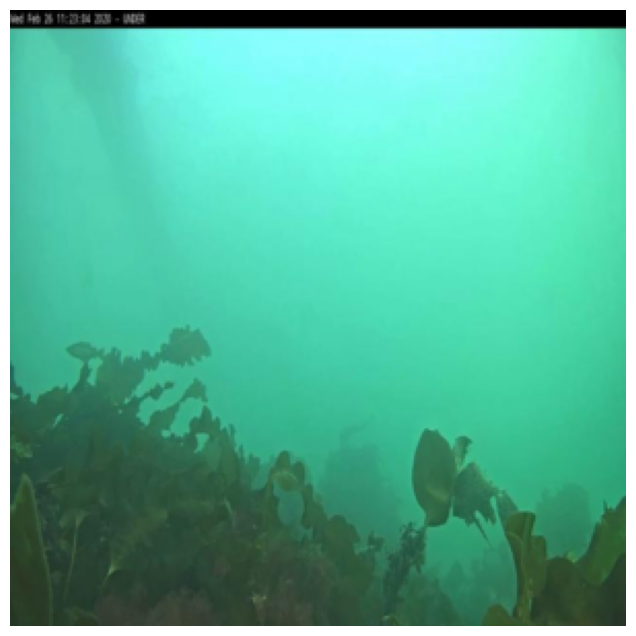

In [117]:
# import matplotlib.pyplot as plt
# import torch
# import numpy as np

# # ÿ™ÿßÿ®ÿπ ÿ®ÿ±ÿß€å ÿ®ÿ±ÿπ⁄©ÿ≥ ⁄©ÿ±ÿØŸÜ ŸÜÿ±ŸÖÿßŸÑ‚Äåÿ≥ÿßÿ≤€å
# def unnormalize(img, mean, std):
#     img = img.clone()
#     for t, m, s in zip(img, mean, std):
#         t.mul_(s).add_(m)
#     return img


#     # ÿ®ÿßÿ±⁄Øÿ∞ÿßÿ±€å ŸÜŸÖŸàŸÜŸá
# img, lbl, bb, (w, h) = train_ds[5]
# #ÿ™ÿ∫€å€åÿ± ÿ±ŸÜ⁄Ø ŸÜŸÖŸàŸÜŸá ÿ®Ÿá ÿ≠ÿßŸÑÿ™ ÿßÿµŸÑ€å ÿ¢ŸÜ
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
# img = unnormalize(img, mean, std)


# # ÿ™ÿ®ÿØ€åŸÑ ÿ®Ÿá numpy ÿ®ÿ±ÿß€å ŸÜŸÖÿß€åÿ¥
# img_np = img.permute(1, 2, 0).numpy()
# img_np = np.clip(img_np, 0, 1)

# plt.figure(figsize=(8, 8))
# plt.imshow(img_np)
# plt.axis('off')


# scale_x = sz / w
# scale_y = sz / h


# # ÿ±ÿ≥ŸÖ ⁄©ÿßÿØÿ±Ÿáÿß (ÿØÿ± ÿ≠ÿßŸÑÿ™ ŸÜÿ±ŸÖÿßŸÑ ÿ¥ÿØŸá €åÿπŸÜ€å ÿ≥ÿß€åÿ≤ 299*299 ⁄ÜŸàŸÜ ÿπ⁄©ÿ≥ ÿ±ÿ≥ŸÖ ÿ¥ÿØŸá ŸáŸÖ ŸáŸÖ€åŸÜ ÿ≥ÿß€åÿ≤ ÿßÿ≥ÿ™)
# for bbox in bb:
#     xmin, ymin, xmax, ymax = bbox

#     xmin = xmin.item()*scale_x
#     ymin = ymin.item()*scale_y
#     xmax = xmax.item()*scale_x
#     ymax = ymax.item()*scale_y

#     print(f"Box: ({xmin:.2f}, {ymin:.2f}) to ({xmax:.2f}, {ymax:.2f})")


#         # ŸÜÿ≥ÿ®ÿ™ ÿ®Ÿá ÿ™ÿµŸà€åÿ± ŸÜŸÖÿß€åÿ¥€å ÿ™ÿ∫€å€åÿ± ŸÖ⁄©ÿßŸÜ
#     display_h, display_w = img_np.shape[:2]

#     plt.gca().add_patch(plt.Rectangle(
#         (xmin, ymin),
#         (xmax - xmin),
#         (ymax - ymin),
#         fill=False, edgecolor='red', linewidth=2))


# plt.show()



## Classification with Localization

<img src='imgs/localization.png' width='90%'/>

### Model

In [113]:
class ClassifierLocalizer(nn.Module):
    def __init__(self, model_name, num_classes=8):
        super(ClassifierLocalizer, self).__init__()
        self.num_classes = num_classes

        # create cnn model
        model = get_model(model_name, num_classes)

        # remove fc layers and add a new fc layer
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes + 4) # classifier + localizer
        self.model = model

    def forward(self, x):
        x = self.model(x)                    # extract features from CNN
        scores = x[:, :self.num_classes]     # class scores
        coords = x[:, self.num_classes:]     # bb corners coordinates
        return scores, torch.sigmoid(coords)     # sigmoid output is in [0, 1]

### Loss Function

Loss function has two parts:
- Cross Entropy Loss (for classification)
- Sum of Squared Errors (for regression)

In [114]:
class LocalizationLoss(nn.Module):
    def __init__(self, num_classes=8):
        super(LocalizationLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss(reduction='sum')
        self.mse_loss = nn.MSELoss(reduction='sum')

    def forward(self, scores, locs, labels, bboxes):
        # Cross Entropy (for classification)
        loss_cls = self.ce_loss(scores, labels)

        # Sum of Squared errors (for corner points)
        loss_r1 = self.mse_loss(locs[:, 0], bboxes[:, 0]) / 2.0
        loss_c1 = self.mse_loss(locs[:, 1], bboxes[:, 1]) / 2.0
        loss_r2 = self.mse_loss(locs[:, 2], bboxes[:, 2]) / 2.0
        loss_c2 = self.mse_loss(locs[:, 3], bboxes[:, 3]) / 2.0

        return loss_cls, loss_r1 + loss_c1 + loss_r2 + loss_c2

In [115]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ClassifierLocalizer(model_name)
model = model.to(device)

criterion = LocalizationLoss()
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

In [116]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, device, scheduler, num_epochs=3)

Epoch 1/3
----------


AttributeError: 'tuple' object has no attribute 'to'

### Predicting bounding boxes

In [ ]:
# load weights
# model.load_state_dict(torch.load('models/resnet34-299-loc-epoch-9-acc-0.97483.pth'))

In [ ]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True)
imgs, lbls, bbs, sizes = next(iter(valid_dl))
scores, locs = model(imgs.to(device))

scores = scores.detach().cpu().numpy()
locs = locs.detach().cpu().numpy()

pred_lbl = np.argmax(scores, axis=1)[0]
pred_bb = locs[0].tolist()

print(pred_lbl, ':', valid_ds.classes[pred_lbl])
w, h = sizes[0].numpy()[0], sizes[1].numpy()[0]

plot_bbox(imgs[0], pred_bb, w, h)

## Other applications

### Key point detection

<img src='imgs/key_points.png' width='80%'/>

### Pose estimation

<img src='imgs/pose.png' width='80%'/>